In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import estimagic as em

# Why optimization is difficult

This tutorial shows why optimization is difficult and why you need some knowledge in order to solve optimization problems efficiently. It is meant for people who have no previous experience with numerical optimization and wonder why there are so many optimization algorithms and still none that works for all problems. For each potential problem we highlight, we also give some ideas on how to solve it. 


If you simply want to learn the mechanics of doing optimization with estimagic, check out the [quickstart guide](../../getting_started/first_optimization_with_estimagic.ipynb)


The message of this notebook can be summarized as follows:

- The only algorithms that are guaranteed to solve all problems are grid search or other algorithms that evaluate the criterion function almost everywhere in the parameter space.
- If you have more than a hand full of parameters these methods would take too long.
- Thus, you have to know the properties of your optimization problem and have knowledge about different optimization algorithms in order to choose the right algorithm for your problem. 

This tutorial uses variants of the sphere function from the [quickstart guide](../../getting_started/first_optimization_with_estimagic.ipynb) to illustrate problems. 

In [2]:
def sphere(params):
    return (params["value"] ** 2).sum()


def sphere_gradient(params):
    return params * 2

## Why grid search is infeasible

Sampling based optimizers and grid search require the parameter space to be bounded in all directions. Let's assume we know that the optimum of the sphere function lies between -0.5 and 0.5, but don't know where it is exactly. 

In order to get a precision of 2 digits with grid search, we require the following number of function evaluations (depending on the number of parameters):

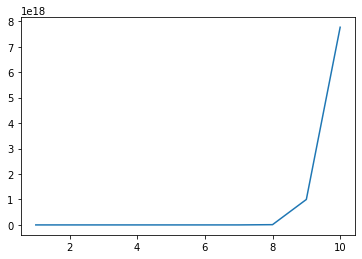

In [3]:
# x-axis: "Dimensionality (number of free parameters) of the problem"
# y-axis: "Number of function evaluations"
dimensions = np.arange(10) + 1
n_evals = 100**dimensions
sns.lineplot(x=dimensions, y=n_evals);

If you have 10 dimensions and evaluating your criterion function takes one second, you need about 3 billion years on a 1000 core cluster. Many of the real world criterion functions have hundreds of parameters and take minutes to evaluate once. This is called the curse of dimensionality.

Sampling based algorithms typically fix the number of criterion evaluations and apply them a bit smarter than algorithms that rummage the search space randomly. However, these smart tricks only work under additional assumptions. Thus, either you need to make assumptions on your problem or you will get the curse of dimensionality through the backdoor again. For easier analysis, assume we fix the number of function evaluations in a grid search instead of a sampling based algorithm and want to know which precision we can get, depending on the dimension:

For 1 million function evaluations, we can expect the following precision:

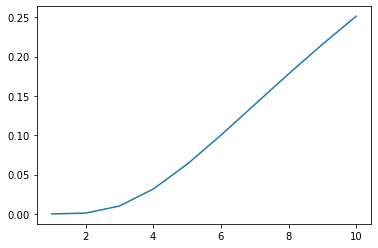

In [4]:
dimensions = np.arange(10) + 1
precision = 1e-6 ** (1 / dimensions)
sns.lineplot(x=dimensions, y=precision);

## How derivatives can solve the curse of dimensionality

Derivative based methods do not try to evaluate the criterion function everywhere in the search space. Instead, they start at some point and go "downhill" from there. The gradient of the criterion function indicates which direction is downhill. Then there are different ways of determining how far to go in that direction. The time it takes to evaluate a derivative increases at most linearly in the number of parameters. Using the derivative information, optimizers can often find an optimum with very few function evaluations.

## How derivative based methods can fail

To see how derivative based methods can fail, we use simple modifications of the sphere function. 

In [5]:
def sphere_with_noise(params):
    return sphere(params) + np.random.normal(scale=0.03)


start_params = pd.DataFrame(
    data=np.arange(5) + 1,
    columns=["value"],
    index=[f"x_{i}" for i in range(5)],
)
start_params

,value
x_0,1
x_1,2
x_2,3
x_3,4
x_4,5


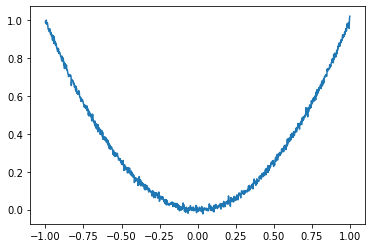

In [6]:
grid = np.linspace(-1, 1, 1000)
sns.lineplot(
    x=grid,
    y=(grid**2) + np.random.normal(scale=0.01, size=len(grid)),
);

In [7]:
np.random.seed(193)
res = em.minimize(
    criterion=sphere_with_noise,
    params=start_params,
    algorithm="scipy_lbfgsb",
    logging=False,
)

res.success

False

In [8]:
res.message

'ABNORMAL_TERMINATION_IN_LNSRCH'

So the algorithm failed, but at least tells you that it did not succed. Let's look at a different kind of numerical noise that could come from rounding. 

In [9]:
def piecewise_constant_sphere(params):
    params = params.copy(deep=True)
    params["value"] = params["value"].round(2)
    return sphere(params)

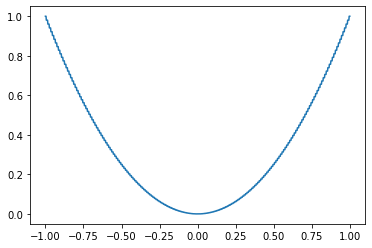

In [10]:
sns.lineplot(x=grid, y=grid.round(2) ** 2);

In [11]:
em.minimize(
    criterion=piecewise_constant_sphere,
    params=start_params,
    algorithm="scipy_lbfgsb",
    logging=False,
)

Minimize with 5 free parameters terminated successfully after 1 criterion evaluations, 1 derivative evaluations and 0 iterations.

The value of criterion improved from 55.0 to 55.0.

The scipy_lbfgsb algorithm reported: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL

This time, the algorithm failed silently.